# Lab 6
## Joshua Min

> **IMPORTANT** to view results go to, and run, the very bottom cell after running the import statements (to avoid having to re-train the model, as this takes around 10 minutes).

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import *
import numpy as np
import pydot
import graphviz
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans
import datetime, os

%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


> Helper function to load filtered (only birds) images

In [94]:
def load_test(cifar10_dataset_folder_path):
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    filtered = np.asarray([x for (i, x) in enumerate(batch['data']) if batch['labels'][i] == 2])
    features = filtered.reshape((len(filtered), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = np.asarray([x for x in batch['labels'] if x == 2])
    
    return features, labels


def load_birds(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    filtered = np.asarray([x for (i, x) in enumerate(batch['data']) if batch['labels'][i] == 2])
    features = filtered.reshape((len(filtered), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = np.asarray([x for x in batch['labels'] if x == 2])
    
    return features, labels

> Loading images and extracting pixel information for K-Means

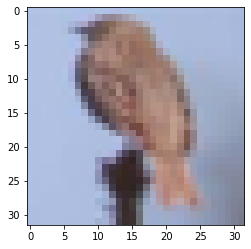

In [95]:
# Load images of birds from all batches
features = None
labels = None

for i in range(1, 6, 1):
    (f, l) = load_birds('./data/cifar-10-batches-py', i)
    if i == 1:
        features = f
        labels = l
    else:
        features = np.append(features, f, axis=0)
        labels = np.append(labels, l)
plt.imshow(features[20])

(test_features, _) = load_test('./data/cifar-10-batches-py')
features = np.append(features, test_features, axis=0)

# Get an array of pixels
pixels = np.ndarray.flatten(features).reshape(-1, 3)

> Clustering pixels and converting each pixel to tetrachrome

In [96]:
kmeans = None
if os.path.exists('./k_means_save.pkl'):
    # Load model if already computed
    kmeans = pickle.load(open('./k_means_save.pkl', 'rb'))
else:
    # Cluster pixels using K-Means
    kmeans = KMeans(
        n_clusters=4,
        init='k-means++',
        max_iter=300,
        n_init=10,
        random_state=0
    )
    pred = kmeans.fit_predict(pixels)
    pickle.dump(kmeans, open("k_means_save.pkl", "wb"))

print(f'Centroids:\n {kmeans.cluster_centers_}')

Centroids:
 [[108.97036568 108.60691289  82.66458238]
 [206.53651167 211.77549799 211.39857871]
 [156.18468173 155.51640472 135.57285659]
 [ 49.02965771  50.01208333  38.57034319]]


In [97]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [98]:
# Convert pixels to tetrachrome and one-hot encode labels
# for each color (centroid)
tetrachrome_pixels = []
tetrachrome_labels = []
for label in kmeans.labels_:
    tetrachrome_pixels.append(kmeans.cluster_centers_[label])
    tetrachrome_labels.append(label)

# Get pixel values/images for sanity check and comparison
tetrachrome_pixels = np.asarray(tetrachrome_pixels)
tetrachrome_images = tetrachrome_pixels.reshape(-1, 32, 32, 3)
test_images = tetrachrome_images[5000:]
tetrachrome_images = tetrachrome_images[:5000]

# Get labels as a flattened array
tetrachrome_labels = np.asarray(tetrachrome_labels)
tetrachrome_labels = tetrachrome_labels.reshape(-1, 32, 32)
tetrachrome_labels = get_one_hot(tetrachrome_labels, 4)

test_labels = tf.convert_to_tensor(
    tetrachrome_labels[5000:].reshape(1000, 32, 32, 4),
    dtype=tf.uint8
)
tetrachrome_labels = tf.convert_to_tensor(
    tetrachrome_labels[:5000].reshape(5000, 32, 32, 4),
    dtype=tf.uint8
)

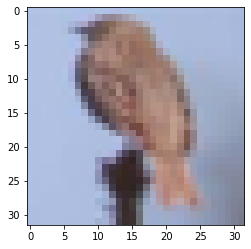

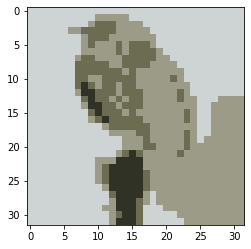

In [99]:
# Show images-- sanity check
plt.imshow(features[20])
plt.figure()
plt.imshow(tetrachrome_images[20] / 255.0)

> Converting images to grayscale

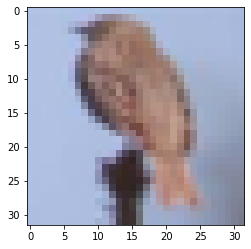

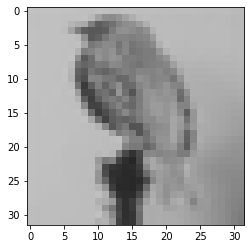

In [100]:
# Converting to grayscale
grayscale_features = tf.image.rgb_to_grayscale(
    features[:5000]
)
grayscale_test_features = tf.image.rgb_to_grayscale(
    features[5000:]
)
grayscale_images = tf.image.grayscale_to_rgb(
    grayscale_features
)
plt.imshow(features[20])
plt.figure()
plt.imshow(grayscale_images[20])

# Normalize input
grayscale_features = grayscale_features / 255
grayscale_test_features = grayscale_test_features / 255

> Creating the model

In [101]:
# Creating the model
model = models.Sequential()

model.add(Conv2D(
    22, 
    (5, 5), 
    padding='same', 
    activation='relu',
    strides=1,
    input_shape=(32,32,1)
))

model.add(MaxPool2D(
    (2,2),
    strides=2
))

model.add(Conv2D(
    133,
    (5, 5), 
    padding='same',
    activation='relu',
))

model.add(MaxPool2D(
    (2,2),
    strides=2
))

model.add(Conv2D(
    256,
    (1, 1), 
    padding='same',
    activation='relu',
))

model.add(Flatten())

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4096))
model.add(Reshape((32, 32, 4)))
model.add(Softmax())

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 32, 22)        572       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 22)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 133)       73283     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 8, 8, 133)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 256)         34304     
_________________________________________________________________
flatten_12 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 2048)            

> Training the model and logging results to Tensorboard

In [102]:
# Log results and train model
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        (loss, accuracy) = model.evaluate(grayscale_test_features, test_labels)
        tf.summary.scalar('test_accuracy', data=accuracy, step=epoch)
        tf.summary.scalar('test_loss', data=loss, step=epoch)


model.fit(
    grayscale_features[:4000], 
    tetrachrome_labels[:4000], 
    epochs=10,
    validation_data=[grayscale_features[4000:], tetrachrome_labels[4000:]],
    callbacks=[tensorboard_callback, TestAccuracyCallback()]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
1000/1 [=====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 35s 9ms/sample - loss: 1.1175 - accuracy: 0.4769 - val_loss: 0.9314 - val_accuracy: 0.5781
Epoch 2/10
1000/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 35s 9ms/sample - loss: 0.8724 - accuracy: 0.6104 - val_loss: 0.8317 - val_accuracy: 0.6280
Epoch 3/10
1000/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 35s 9ms/sample - loss: 0.7840 - accuracy: 0.6540 - val_loss: 0.7606 - val_accuracy: 0.6627
Epoch 4/10
1000/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 35s 9ms/sample - loss: 0.7393 - accuracy: 0.6755 - val_loss: 0.7159 - val_accuracy: 0.6839
Epoch 5/10
1000/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 36s 9ms/sample - loss: 0.7013 - accuracy: 0.6930 - val_loss: 0.6935 - val_accuracy: 0.6947
Epoch 6/10
1000/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 35s 9ms/sample - loss: 0.6813 - accuracy: 0.7015 - val_loss: 0.7014 - val_accuracy: 0.6874
Epoch 7/10
1000/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 36s 9ms/sample - loss: 0.6492 - accuracy: 0.7169 - val_loss: 0.6733 - val_accuracy: 0.7043
Epoch 8/10
1000/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 34s 9ms/sample - loss: 0.6204 - accuracy: 0.7311 - val_loss: 0.6545 - val_accuracy: 0.7101
Epoch 9/10
1000/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 35s 9ms/sample - loss: 0.5992 - accuracy: 0.7411 - val_loss: 0.6524 - val_accuracy: 0.7124
Epoch 10/10
1000/1 [============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4000/4000 [==============================] - 34s 8ms/sample - loss: 0.5745 - accuracy: 0.7530 - val_loss: 0.6418 - val_accuracy: 0.7180


> Sanity check-- show predicted image

In [103]:
# Save our predictions
pred = model.predict(grayscale_features).reshape(5000, 32, 32, 4)

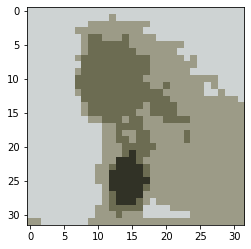

In [104]:
# Show predicted image-- sanity check
predicted_image = []
for row in pred[20]:
    for pixel in row:
        predicted_image.append(kmeans.cluster_centers_[np.argmax(pixel)])
predicted_image = np.asarray(predicted_image) / 255
predicted_image = predicted_image.reshape(32, 32, 3)
plt.imshow(predicted_image)

> Display graphs of validation loss/accuracy and test loss/accuracy per-epoch

In [105]:
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 9465), started 0:08:59 ago. (Use '!kill 9465' to kill it.)